In [89]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [90]:
DATA_DIR_PATH = '/home/brother_gyu/dev/catboost_recipe_classifier/data'
USER_DATA_CSV_NAME = 'sequence_final.csv'
CATEGORY_DATA_CSV_NAME = 'cate_data_final.csv'

In [91]:
# 유저 레시피 평점 상호작용 데이터 로드 및 전처리
user_df = pd.read_csv(os.path.join(DATA_DIR_PATH, USER_DATA_CSV_NAME))
user_df.rename(columns={'rid': 'recipeid'}, inplace=True)
user_df.drop(['star'], axis=1, inplace=True)

In [92]:
cate_df = pd.read_csv(os.path.join(DATA_DIR_PATH, CATEGORY_DATA_CSV_NAME))
cate_df = cate_df.drop(['thumb_link'], axis=1)

offset = 0
for col in cate_df.columns[1:]:
    unique_vals = sorted(cate_df[col].unique())
    mapping_dict = {val: i for i, val in enumerate(unique_vals, start=offset)}
    cate_df[col] = cate_df[col].map(mapping_dict)
    offset += len(unique_vals)

In [93]:
print(sorted(cate_df['cat1'].unique()))
print(sorted(cate_df['cat2'].unique()))
print(sorted(cate_df['cat3'].unique()))
print(sorted(cate_df['cat4'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
[44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]


# Train Dataset 전처리

In [94]:
df_encoded = pd.get_dummies(cate_df, columns=["cat1", "cat2", "cat3", "cat4"])
df_encoded = df_encoded.astype(int)

# 새로운 열 이름 생성
new_columns = ["recipeid"] + [str(i) for i in range(len(df_encoded.columns) - 1)]
# 열 이름 변경
df_encoded.columns = new_columns

user_data_df = pd.merge(user_df, df_encoded, on="recipeid").sort_values(by=["uid", "time"]).reset_index(drop=True)
user_data_df = user_data_df.drop(['time'], axis=1)

## - apply, transform 선택

### (선택 1) apply

In [95]:
df_grouped = user_data_df.groupby("uid").apply(lambda x: x.iloc[:, 2:].cumsum()).reset_index(drop=True)
df_grouped = pd.concat([user_data_df[["recipeid"]], df_grouped], axis=1)

In [96]:
df_grouped.head()

,recipeid,0,1,2,3,4,5,6,7,8,...,51,52,53,54,55,56,57,58,59,60
0,6856432,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,6885928,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,6886836,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,6892249,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,6849655,0,0,0,1,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0


### (선택 2) transform

In [57]:
cols_to_cumsum = user_data_df.columns[2:]
df_grouped = user_data_df.copy()
df_grouped[cols_to_cumsum] = user_data_df.groupby("uid")[cols_to_cumsum].transform(lambda x: x.cumsum())
df_grouped = pd.concat([user_data_df[["recipeid"]], df_grouped[cols_to_cumsum]], axis=1)

In [58]:
df_grouped.head()

,recipeid,0,1,2,3,4,5,6,7,8,...,51,52,53,54,55,56,57,58,59,60
0,6856432,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,6885928,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,6886836,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,6892249,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,6849655,0,0,0,1,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0


## - 스케일링 방법 선택

### (선택 1) 카테고리 별로 나눠서 독립적으로 스케일링

In [97]:
df_grouped = user_data_df.groupby("uid").apply(lambda x: x.iloc[:, 2:].cumsum()).reset_index(drop=True)
df_grouped = pd.concat([user_data_df[["recipeid"]], df_grouped], axis=1)

max_values_1 = df_grouped.iloc[:, 1:15].max(axis=1)
max_values_2 = df_grouped.iloc[:, 15:29].max(axis=1)
max_values_3 = df_grouped.iloc[:, 29:45].max(axis=1)
max_values_4 = df_grouped.iloc[:, 45:62].max(axis=1)
df_grouped.iloc[:, 1:15] = df_grouped.iloc[:, 1:15].div(max_values_1, axis=0).round(2)
df_grouped.iloc[:, 15:29] = df_grouped.iloc[:, 15:29].div(max_values_2, axis=0).round(2)
df_grouped.iloc[:, 29:45] = df_grouped.iloc[:, 29:45].div(max_values_3, axis=0).round(2)
df_grouped.iloc[:, 45:62] = df_grouped.iloc[:, 45:62].div(max_values_4, axis=0).round(2)

In [47]:
df_grouped

,recipeid,0,1,2,3,4,5,6,7,8,...,51,52,53,54,55,56,57,58,59,60
0,6856432,0.00,0.0,0.0,0.0,0.00,0.00,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,6885928,0.00,0.0,0.0,0.0,0.00,0.00,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,6886836,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.5,0.0,...,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0
3,6892249,0.00,0.0,0.0,0.5,0.00,0.00,0.0,0.5,0.0,...,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0
4,6849655,0.00,0.0,0.0,0.5,0.00,0.50,0.0,0.5,0.0,...,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152764,6877808,0.33,1.0,0.0,0.0,0.33,0.33,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
152765,6914132,0.00,1.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
152766,6909646,0.00,1.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
152767,6865345,0.00,1.0,0.5,0.0,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0


### (선택 2) 행 별로 독립적으로 스케일링

In [49]:
df_grouped = user_data_df.groupby("uid").apply(lambda x: x.iloc[:, 2:].cumsum()).reset_index(drop=True)
df_grouped = pd.concat([user_data_df[["recipeid"]], df_grouped], axis=1)

max_values = df_grouped.iloc[:, 1:].max(axis=1)
df_grouped.iloc[:, 1:] = df_grouped.iloc[:, 1:].div(max_values, axis=0).round(2)

In [50]:
df_grouped

,recipeid,0,1,2,3,4,5,6,7,8,...,51,52,53,54,55,56,57,58,59,60
0,6856432,0.00,0.00,0.00,0.00,0.00,0.00,0.0,1.00,0.0,...,0.0,0.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0
1,6885928,0.00,0.00,0.00,0.00,0.00,0.00,0.0,1.00,0.0,...,0.0,0.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0
2,6886836,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.50,0.0,...,0.0,0.0,0.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0
3,6892249,0.00,0.00,0.00,0.50,0.00,0.00,0.0,0.50,0.0,...,0.0,0.0,0.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0
4,6849655,0.00,0.00,0.00,0.33,0.00,0.33,0.0,0.33,0.0,...,0.0,0.0,0.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152764,6877808,0.17,0.50,0.00,0.00,0.17,0.17,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.83,0.0,0.0,0.0,0.0,0.0
152765,6914132,0.00,1.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
152766,6909646,0.00,1.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
152767,6865345,0.00,1.00,0.50,0.00,0.00,0.00,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0


## - 레시피 출현 빈도 파악

In [87]:
count_df = pd.DataFrame()
count_df['count'] = list(df_grouped['recipeid'].value_counts())
# Count Value 20 이상을 20으로 설정
# count_df['count'] = count_df['count'].apply(lambda x: 20 if x >= 20 else x)
# count_df = count_df[count_df['count'] < 10]

In [99]:
count_df = pd.DataFrame()
count_df['count'] = list(df_grouped['recipeid'].value_counts())

# 사분위수 계산
Q1 = count_df['count'].quantile(0.25)
Q2 = count_df['count'].quantile(0.50)
Q3 = count_df['count'].quantile(0.75)
print("Q1:", Q1)
print("Q2:", Q2)
print("Q3:", Q3)

Q1: 1.0
Q2: 1.0
Q3: 3.0


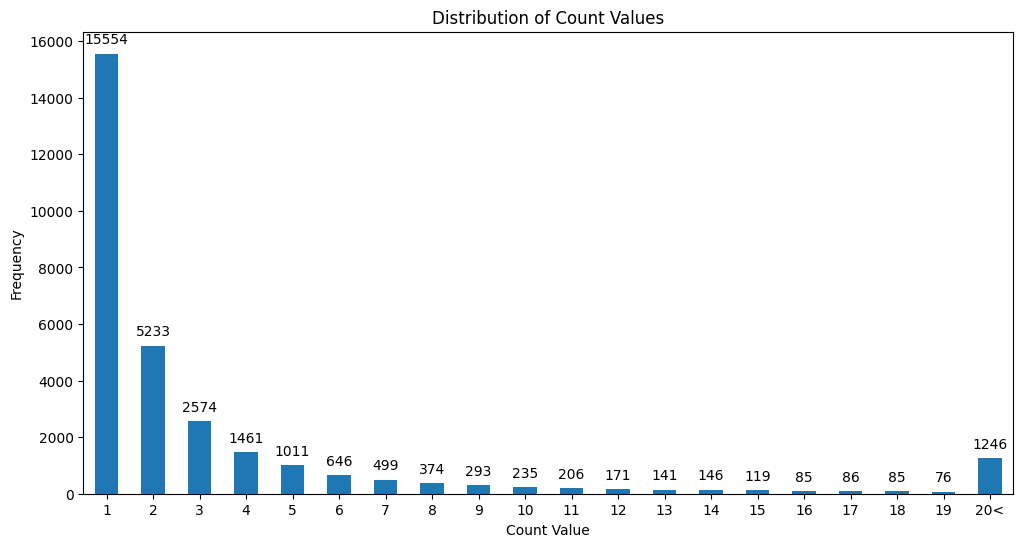

In [76]:
# count의 빈도수 계산
value_counts = count_df['count'].value_counts().sort_index()

# 시각화
plt.figure(figsize=(12, 6))
ax = value_counts.plot(kind='bar')
plt.title('Distribution of Count Values')
plt.xlabel('Count Value')
plt.ylabel('Frequency')
# 각 막대 위에 숫자를 표시
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# 마지막 x축 라벨 변경
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[-1] = '20<'
ax.set_xticklabels(labels, rotation=0)

plt.show()

# - 출현 빈도가 적은 레시피 제거

In [82]:
# 레시피 상호작용이 10회 이하인 유저 제외
df_grouped = df_grouped.groupby('recipeid').filter(lambda x: len(x) > 10)
# 인덱스 초기화하면서 기존 인덱스 삭제
df_grouped = df_grouped.reset_index(drop=True)

In [15]:
# 저장
df_grouped.to_csv("train_data_all.csv", index=False)

In [14]:
df_grouped

,recipeid,0,1,2,3,4,5,6,7,8,...,51,52,53,54,55,56,57,58,59,60
0,6885928,0.00,0.00,0.00,0.00,0.00,0.00,0.0,1.00,0.0,...,0.0,0.0,0.0,0.0,1.00,0.0,0.00,0.0,0.0,0.0
1,6892249,0.00,0.00,0.00,0.50,0.00,0.00,0.0,0.50,0.0,...,0.0,0.0,0.0,0.0,0.50,0.0,0.00,0.0,0.0,0.0
2,6879215,0.00,0.33,0.00,0.33,0.00,0.33,0.0,0.33,0.0,...,0.0,0.0,0.0,0.0,0.33,0.0,0.00,0.0,0.0,0.0
3,6843983,0.00,0.75,0.00,0.25,0.00,0.25,0.0,0.25,0.0,...,0.0,0.0,0.0,0.0,0.50,0.0,0.25,0.0,0.0,0.0
4,6857197,0.00,0.80,0.00,0.20,0.00,0.20,0.0,0.20,0.0,...,0.0,0.0,0.0,0.0,0.60,0.0,0.20,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92775,6869163,0.17,0.33,0.00,0.00,0.17,0.17,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.67,0.0,0.00,0.0,0.0,0.0
92776,6877808,0.17,0.50,0.00,0.00,0.17,0.17,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.83,0.0,0.00,0.0,0.0,0.0
92777,6909646,0.00,1.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0
92778,6865345,0.00,1.00,0.50,0.00,0.00,0.00,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.50,0.0,0.00,0.0,0.0,0.0


### df_grouped에서 0이 차지하는 비율

In [31]:
zero_counts = (df_grouped == 0).sum().sum()
print(zero_counts / (len(df_grouped) * (len(df_grouped.keys()) - 1)) * 100)

74.4279434162959


# recipe category csv onehot 변경

> mongodb input용 데이터 전처리
>
> recipe category를 미리 onehot데이터로 변경하여 연산 최적화

In [32]:
df = pd.read_csv("train_data.csv")
len(df['recipeid'].unique())

2361

In [33]:
df_encoded = pd.get_dummies(cate_df, columns=["cat1", "cat2", "cat3", "cat4"])
df_encoded = df_encoded.replace({False: 0, True: 1})
# 새로운 열 이름 생성
new_columns = ["recipeid"] + [str(i) for i in range(61)]
# 열 이름 변경
df_encoded.columns = new_columns
# "category_list" 열 생성
df_encoded["category_list"] = df_encoded.apply(lambda row: [row[str(i)] for i in range(61)], axis=1)

# "recipeid", "category_list" 열 선택
df_encoded = df_encoded[["recipeid", "category_list"]]

df_encoded.to_csv("category_onehot.csv", index=False)

In [34]:
df_encoded

,recipeid,category_list
0,6912734,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ..."
1,6843136,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2,7002443,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
3,6996297,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ..."
4,6885909,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
...,...,...
120824,7004885,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
120825,7004887,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
120826,7004898,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ..."
120827,7004906,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
